In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pyslaw.pyslaw import calculate_agw

# Analytical solution of the flow over the Witch of Agnesi hill

TODO:
- Add short description here (include author?)
- Cleanup visualization (e.g. midpointnorm)
- Cleanup sandbox

Flow parameters

In [7]:
U = 10   # Wind speed [m/s]
N = 0.01 # Brunt-Vaisala frequency [1/s]

Hill shape

In [8]:
L = 1000.0   # Characteristic width of the hill [m]
hmax = 100.0 # Height of the hill [m]

# Shape function of the hill
h = lambda x: hmax/(1+(x/L)**2)

Numerical parameters

In [9]:
Lx = 2000.0e3  # Length of the numerical domain [m]
Nx = int(1e5) # Number of grid points

## Solve flow problem

Create numerical grid

In [10]:
xs,dx = np.linspace(-Lx/2,Lx/2,Nx,endpoint=False,retstep=True)
Nz = 151
zs = np.linspace(0,15000,Nz)
print('Grid resolution is {} m'.format(dx))

Grid resolution is 20.0 m


In [11]:
%%time
eta = calculate_agw(xs,zs,h(xs),U,N)

CPU times: user 972 ms, sys: 392 ms, total: 1.36 s
Wall time: 1.64 s


## Visualization

In [233]:
#Self defined norm function
from matplotlib.colors import Normalize

class midpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

(-50000.0, 50000.0)

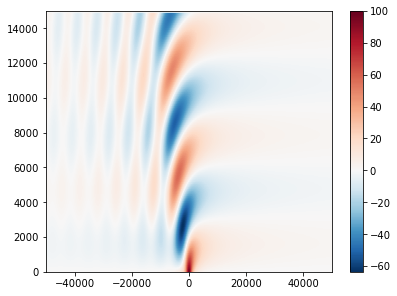

In [234]:
f,ax=plt.subplots(1,1,figsize=(6.4,4.8))

vmin = np.min(eta)
vmax = np.max(eta)

extent = [xs[0], xs[-1], zs[0], zs[-1]]
im=ax.imshow(np.fliplr(eta).T,extent=extent,aspect='auto',cmap='RdBu_r',norm=midpointNormalize(midpoint=0))
cbar = f.colorbar(im,ax=ax,shrink=1.0)
ax.set_xlim([-50e3,50e3])

## Sandbox

In [113]:
%%timeit
np.fft.fft(h(xs))

8.07 µs ± 486 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [96]:
%%timeit
np.fft.rfft(h(xs))

8.03 µs ± 323 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [166]:
hc = np.fft.rfft(h(xs))/Nx
hc

array([ 27.56108597+0.00000000e+00j, -17.37180385+0.00000000e+00j,
         8.98423277-3.55271368e-16j,  -5.27073009-3.55271368e-16j,
         3.19676271+0.00000000e+00j,  -2.7918552 +0.00000000e+00j])

In [167]:
hc.size

6

In [168]:
hc = np.fft.fftshift(np.fft.fft(h(xs)))/Nx
hc

array([ -2.7918552 +0.j,   3.19676271+0.j,  -5.27073009+0.j,
         8.98423277+0.j, -17.37180385+0.j,  27.56108597+0.j,
       -17.37180385+0.j,   8.98423277+0.j,  -5.27073009+0.j,
         3.19676271+0.j])

In [156]:
ks = 2.0*np.pi*np.fft.fftshift(np.fft.fftfreq(int(Nx),dx))

In [157]:
ks

array([-0.00314159, -0.00251327, -0.00188496, -0.00125664, -0.00062832,
        0.        ,  0.00062832,  0.00125664,  0.00188496,  0.00251327])

In [158]:
ks_real = 2.0*np.pi*np.fft.rfftfreq(int(Nx),dx)

In [159]:
def vertical_wavenumber(k,U,N):
    m = np.zeros(k.shape,dtype=np.complex128)
    #Propagating waves
    iprop = np.where((U*k)**2>N**2)
    #Evanescent waves (excluding where U*k=0, for which m is set to zero) 
    ievan = np.where(~(((-U*k)==0) | ((U*k)**2>N**2)))
    print('Propagating modes',iprop)
    print('Evanescent modes',ievan)


    m[iprop] = 1j*np.abs(k[iprop])*np.sqrt(1-N**2/(U*k[iprop])**2)
    m[ievan] = -np.sign(-U*k[ievan])*np.abs(k[ievan])*np.sqrt(N**2/(U*k[ievan])**2-1)
    return m

In [160]:
vertical_wavenumber(ks,U,N)

Propagating modes (array([0, 1, 2, 3, 7, 8, 9]),)
Evanescent modes (array([4, 6]),)


array([ 0.        +0.00297819j,  0.        +0.00230576j,
        0.        +0.00159783j,  0.        +0.00076101j,
       -0.00077796+0.j        ,  0.        +0.j        ,
        0.00077796+0.j        ,  0.        +0.00076101j,
        0.        +0.00159783j,  0.        +0.00230576j])

In [116]:
vertical_wavenumber(ks_real,U,N)

Propagating modes (array([1, 2, 3, 4, 5]),)
Evanescent modes (array([], dtype=int64),)


array([0.+0.j        , 0.+0.0062031j , 0.+0.01252652j, 0.+0.01882301j,
       0.+0.02511284j, 0.+0.03140001j])

In [105]:
hc

array([-0.32154449+0.j, -0.35603627+0.j, -0.49506021+0.j, -0.95534003+0.j,
       -4.34416755+0.j, 92.62275259+0.j, -4.34416755+0.j, -0.95534003+0.j,
       -0.49506021+0.j, -0.35603627+0.j])

In [161]:
hc * np.exp(1j*m*1)

array([-0.32154434+0.00030526j, -0.3560361 +0.00034461j,
       -0.49505997+0.00048619j, -0.95533956+0.00094777j,
       -4.34416538+0.00433558j, 92.62275259+0.j        ,
       -4.34416538-0.00433558j, -0.95533956-0.00094777j,
       -0.49505997-0.00048619j, -0.3560361 -0.00034461j])

In [162]:
1j*ks*U*hc * np.exp(1j*m*1)

array([9.59017468e-06+0.01010161j, 8.66094896e-06+0.00894816j,
       9.16438457e-06+0.00933166j, 1.19099888e-05+0.01200515j,
       2.72412733e-05+0.0272952j , 0.00000000e+00+0.j        ,
       2.72412733e-05-0.0272952j , 1.19099888e-05-0.01200515j,
       9.16438457e-06-0.00933166j, 8.66094896e-06-0.00894816j])

In [173]:
hc.shape

(10,)

In [ ]:
%%time
Nz = 151
Lz = 15000
zs = np.linspace(0,Lz,Nz)
etac = np.zeros((Nz,Nx,Nt),dtype=np.complex128)
for i,z in enumerate(zs):
    etac[i,:,:] = hc * np.exp(1j*m*z)
    etac[i,0,:] = 0.0 #Set defunct modes to zero
    etac[i,:,0] = 0.0 #Set defunct modes to zero
    #wc   = 1j*Omegas*etac
    ##uc   = -1j*m*U*etac
    ##pc   = 1j*m*U**2*etac
    ##uc[int(Nx/2)] = 0.0 #Set mean mode to zero
    ##pc[int(Nx/2)] = 0.0#Set mean mode to zero
    #etar[:,:,i] = np.real(np.fft.ifft2(np.fft.ifftshift(etac*Nx*Nt)))
    #wr[:,:,i] = np.real(np.fft.ifft2(np.fft.ifftshift(wc*Nx*Nt)))
    ##ur[:,i] = np.real(np.fft.ifft(np.fft.ifftshift(uc*Nx)))
    ##pr[:,i] = np.real(np.fft.ifft(np.fft.ifftshift(pc*Nx)))
wc = 1j*Omegas[np.newaxis,...]*etac
etar = np.real(np.fft.ifft2(np.fft.ifftshift(etac*Nx*Nt,axes=(1,2))))
wr = np.real(np.fft.ifft2(np.fft.ifftshift(wc*Nx*Nt,axes=(1,2))))

In [198]:
hc.shape

(10,)

In [199]:
hc[:,np.newaxis].

(10, 1)

In [201]:
np.exp(1j*m*zs)

ValueError: operands could not be broadcast together with shapes (10,) (151,) 

In [204]:
mz=m[:,np.newaxis]*zs
mz.shape

(10, 151)

In [207]:
(hc[:,np.newaxis]*mz).shape

(10, 151)